In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd

from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, random_split

torch.manual_seed(0)

In [2]:
data_path    = Path('../data/')
model_folder = Path('../models/')
model_path   = model_folder / 'edlvl_clf.pt'
df           = pd.read_csv(data_path / 'interim' / 'fed_emp.csv')

In [3]:
# Removing the lines for which the target in unknown
df                                   = df[~df.EDLVL.isnull()]
# Removing the nan values in columns by either adding a new category
# or dropping the lines
df.loc[df.GSEGRD.isnull(), 'GSEGRD'] = 0
df.loc[df.OCC.isnull(), 'OCC']       = 0
df                                   = df[~df.SUPERVIS.isnull()]
df                                   = df[~df.TOA.isnull()]
df                                   = df[~df.SALARY.isnull()]
df                                   = df[~df.LOS.isnull()]
# df.isnull().sum(axis = 0)

In [4]:
df_data    = df.drop(['EDLVL'], axis = 1)
df_target  = df['EDLVL']
df_target  = df_target - 1 # Values between 0 and 21 instead of 1 and 22
# df_target.hist(bins = 22)

In [5]:
numerical_columns = ['SALARY', 'LOS']
df_num            = df_data[numerical_columns]
num_val_mean      = df_num.mean(axis = 0)
num_val_std       = df_num.std(axis = 0)
df_num            = (df_num - num_val_mean) / num_val_std
df_cat            = df_data.drop(numerical_columns, axis = 1) 

In [6]:
columns_encoders = {
    col : {
        val : i 
        for i, val in enumerate(df[col].unique())
    }
    for col in df_cat.columns
}
column_order = sorted(columns_encoders.keys())

In [7]:
for col in df_cat.columns:
    df_cat[col] = df_cat[col].apply(lambda x: columns_encoders[col][x])

In [8]:
class CategoricalEmbeddings(nn.Module):
    def __init__(self, col_order, col_encoders, col_to_emb_dim):
        super(CategoricalEmbeddings, self).__init__()
        self.col_order = col_order 
        self.cat_embs  = nn.ModuleDict({
            col: nn.Embedding(len(col_encoders[col]), col_to_emb_dim[col])
            for col in col_order
        })
        
    def forward(self, cat_variables):
        embeddings = [self.cat_embs[col](cat_variables[col]) for col in self.col_order]
        
        return torch.cat(embeddings, dim = 1)

In [9]:
class EdlvlClassifier(nn.Module):
    def __init__(self, col_order, col_encoders, col_to_emb_dim, lin_size = 256, dropout_rate = 0.):
        super(EdlvlClassifier, self).__init__()
        self.cat_emb    = CategoricalEmbeddings(col_order, col_encoders, col_to_emb_dim)
        sum_cat_emb_dim = sum(col_to_emb_dim.values())
        self.linear1    = nn.Linear(sum_cat_emb_dim + 2, lin_size)
        self.linear2    = nn.Linear(lin_size, 22)
        self.dropout    = nn.Dropout(dropout_rate)
        
    def forward(self, cat_variables, num_variables):
        cat_embeddings = self.cat_emb(cat_variables)
        cat_num_tensor = torch.cat([cat_embeddings, num_variables], dim = 1)
        cat_num_tensor = self.dropout(cat_num_tensor)
        out_linear1    = F.relu(self.dropout(self.linear1(cat_num_tensor)))
        out_linear2    = self.linear2(out_linear1)
        
        return out_linear2

In [10]:
model = EdlvlClassifier(
    column_order,
    columns_encoders,
    {
        col : 4
        for col in columns_encoders
    }
)
model

EdlvlClassifier(
  (cat_emb): CategoricalEmbeddings(
    (cat_embs): ModuleDict(
      (AGELVL): Embedding(12, 4)
      (AGYSUB): Embedding(523, 4)
      (GSEGRD): Embedding(16, 4)
      (LOC): Embedding(219, 4)
      (LOSLVL): Embedding(10, 4)
      (OCC): Embedding(656, 4)
      (PATCO): Embedding(7, 4)
      (PPGRD): Embedding(933, 4)
      (SALLVL): Embedding(25, 4)
      (STEMOCC): Embedding(100, 4)
      (SUPERVIS): Embedding(6, 4)
      (TOA): Embedding(18, 4)
      (WORKSCH): Embedding(10, 4)
      (WORKSTAT): Embedding(2, 4)
    )
  )
  (linear1): Linear(in_features=58, out_features=256, bias=True)
  (linear2): Linear(in_features=256, out_features=22, bias=True)
  (dropout): Dropout(p=0.0)
)

In [11]:
dataset = TensorDataset(
    *[
        torch.tensor(df_cat[col].values)
        for col in column_order
    ], # categorical variables in the correct order
    torch.tensor(df_num.values, dtype = torch.float32), # numerical variables
    torch.tensor(df_target.values, dtype = torch.int64) # target variables
)

In [12]:
dataset_size                 = len(dataset)
valid_prop                   = 0.2
valid_size                   = round(valid_prop * dataset_size)
lengths                      = [dataset_size - valid_size, valid_size]
train_dataset, valid_dataset = random_split(dataset, lengths)

In [13]:
train        = False
device       = torch.device('cuda')
model        = model.to(device)
epochs       = 5
batch_size   = 2048
optimizer    = optim.Adam(model.parameters())
criterion    = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)

In [14]:
# if train:
#     for epoch in range(epochs):
#         correct = 0
#         total   = 0
#         for i, (*cat_var_list, num_var, y) in enumerate(train_loader):
#             optimizer.zero_grad()
#             cat_var_list   = [t.to(device) for t in cat_var_list]
#             num_var        = num_var.to(device)
#             y              = y.to(device)
#             cat_variables  = dict(zip(column_order, cat_var_list))
#             res            = model(cat_variables, num_var)
#             loss           = criterion(res, y)
#             correct       += (res.argmax(dim = 1) == y).detach().sum().item()
#             total         += y.shape[0]
#             loss.backward()
#             optimizer.step()
#             if i % 300 == 0: 
#                 model.eval()
#                 valid_correct = 0
#                 valid_total   = 0
#                 with torch.no_grad():
#                     for *cat_var_list, num_var, y in valid_loader:
#                         cat_var_list   = [t.to(device) for t in cat_var_list]
#                         num_var        = num_var.to(device)
#                         y              = y.to(device)
#                         cat_variables  = dict(zip(column_order, cat_var_list))
#                         res            = model(cat_variables, num_var)
#                         valid_correct += (res.argmax(dim = 1) == y).detach().sum().item()
#                         valid_total   += y.shape[0]
#                 print(valid_correct, valid_total)
#                 print(f'[{epoch}:{i}] [T] {100. * correct / total:5.2f}%, [V] {100. * valid_correct / valid_total:5.2f}% {loss.item():5.2f}')
#                 model.train()

#     torch.save(model.state_dict(), model_path)

In [15]:
if train:
    for epoch in range(epochs):
        correct = 0
        total   = 0
        for i, (*cat_var_list, num_var, y) in enumerate(train_loader):
            optimizer.zero_grad()
            cat_var_list   = [t.to(device) for t in cat_var_list]
            num_var        = num_var.to(device)
            y              = y.to(device)
            cat_variables  = dict(zip(column_order, cat_var_list))
            res            = model(cat_variables, num_var)
            loss           = criterion(res, y)
            correct       += (res.argmax(dim = 1) == y).detach().sum().item()
            total         += y.shape[0]
            loss.backward()
            optimizer.step()
        model.eval()
        valid_correct = 0
        valid_total   = 0
        with torch.no_grad():
            for *cat_var_list, num_var, y in valid_loader:
                cat_var_list   = [t.to(device) for t in cat_var_list]
                num_var        = num_var.to(device)
                y              = y.to(device)
                cat_variables  = dict(zip(column_order, cat_var_list))
                res            = model(cat_variables, num_var)
                valid_correct += (res.argmax(dim = 1) == y).detach().sum().item()
                valid_total   += y.shape[0]
        print(valid_correct, valid_total)
        print(f'[{epoch}:{i}] [T] {100. * correct / total:5.2f}%, [V] {100. * valid_correct / valid_total:5.2f}% {loss.item():5.2f}')
        model.train()

    torch.save(model.state_dict(), model_path)

174406 362579
[0:708] [T] 45.25%, [V] 48.10%  1.41
178464 362579
[1:708] [T] 48.82%, [V] 49.22%  1.52
180416 362579
[2:708] [T] 49.58%, [V] 49.76%  1.60
181762 362579
[3:708] [T] 49.99%, [V] 50.13%  1.48
182148 362579
[4:708] [T] 50.24%, [V] 50.24%  1.41


In [16]:
model = EdlvlClassifier(
    column_order,
    columns_encoders,
    {
        col : 4
        for col in columns_encoders
    }
).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()
valid_correct = 0
valid_total   = 0
with torch.no_grad():
    for *cat_var_list, num_var, y in valid_loader:
        cat_var_list   = [t.to(device) for t in cat_var_list]
        num_var        = num_var.to(device)
        y              = y.to(device)
        cat_variables  = dict(zip(column_order, cat_var_list))
        res            = model(cat_variables, num_var)
        valid_correct += (res.argmax(dim = 1) == y).detach().sum().item()
        valid_total   += y.shape[0]
print(valid_correct / valid_total)

0.5023677598537146


In [17]:
*cat_var_list, num_var, y = train_dataset[5]
cat_var_list   = [t.to(device) for t in cat_var_list]
num_var        = num_var.to(device)
y              = y.to(device)
cat_variables  = dict(zip(column_order, [t.unsqueeze(0) for t in cat_var_list]))
res            = model(cat_variables, num_var.unsqueeze(0))
print(y.item(), res.argmax(dim = 1).item())

16 16


In [60]:
np.zeros(shape = 3)

array([0., 0., 0.])

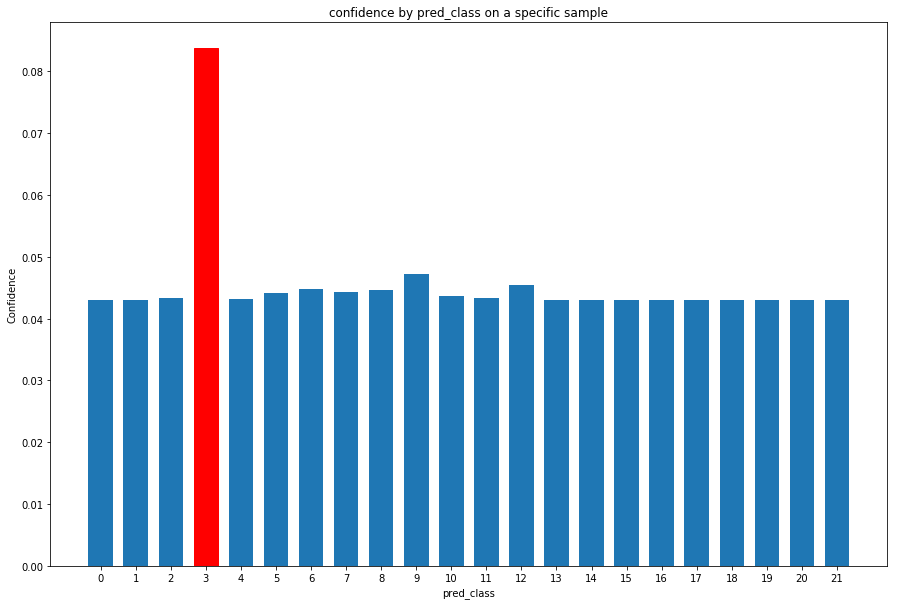

In [65]:
def plot(index, res, x_label, correct_index = None):
    fig, ax = plt.subplots(figsize = (15, 10))
    bar_width = .70
    if correct_index is None:
        ax.bar(index, res, bar_width)
    else:
        barlist = ax.bar(index, res, bar_width)
        barlist[correct_index].set_color('r')
    ax.set_xticks(index)
    ax.set_xticklabels(index)
    ax.set_title(f'confidence by {x_label} on a specific sample')
    ax.set_xlabel(x_label)
    ax.set_ylabel('Confidence')
    
plot(np.arange(len(res[0])), torch.softmax(res, dim = 1).detach().cpu().numpy()[0], 'pred_class', 3)

In [81]:
sample_idx = 13

In [82]:
*cat_var_list, num_var, y = train_dataset[sample_idx]
cat_var_list   = [t.to(device) for t in cat_var_list]
num_var        = num_var.to(device)
y              = y.to(device)
cat_variables  = dict(zip(column_order, [t.unsqueeze(0) for t in cat_var_list]))
res            = model(cat_variables, num_var.unsqueeze(0))
print(y.item(), res.argmax(dim = 1).item())
print(cat_variables)

3 3
{'AGELVL': tensor([5], device='cuda:0'), 'AGYSUB': tensor([58], device='cuda:0'), 'GSEGRD': tensor([8], device='cuda:0'), 'LOC': tensor([34], device='cuda:0'), 'LOSLVL': tensor([1], device='cuda:0'), 'OCC': tensor([191], device='cuda:0'), 'PATCO': tensor([4], device='cuda:0'), 'PPGRD': tensor([11], device='cuda:0'), 'SALLVL': tensor([14], device='cuda:0'), 'STEMOCC': tensor([1], device='cuda:0'), 'SUPERVIS': tensor([0], device='cuda:0'), 'TOA': tensor([0], device='cuda:0'), 'WORKSCH': tensor([0], device='cuda:0'), 'WORKSTAT': tensor([0], device='cuda:0')}


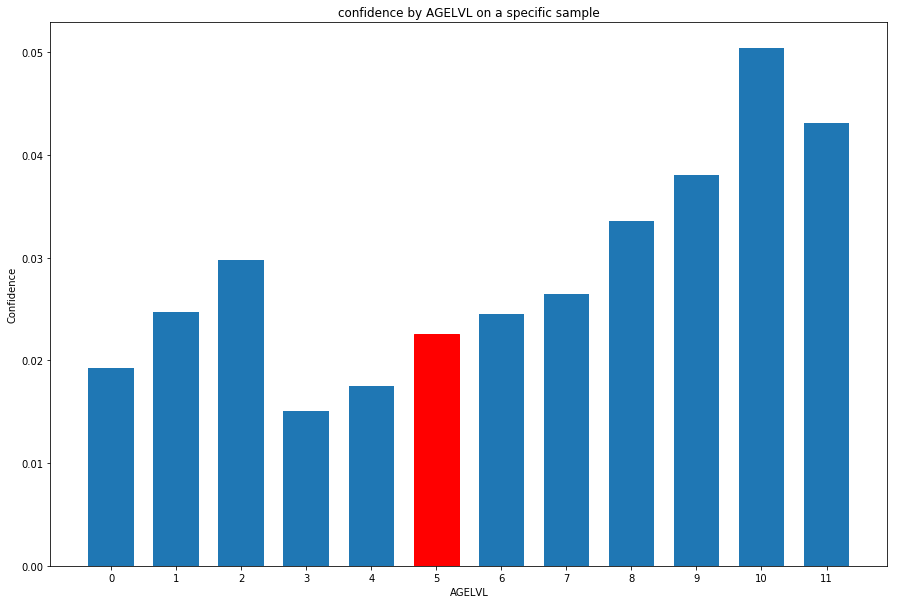

In [83]:
*cat_var_list, num_var, y = train_dataset[10]
cat_var_list   = [t.to(device) for t in cat_var_list]
num_var        = num_var.to(device)
y              = y.to(device)
cat_variables  = dict(zip(column_order, [t.unsqueeze(0) for t in cat_var_list]))
orig_age_lvl   = cat_variables['AGELVL'].item()
confidences = []
age_lvls = list(range(12))
for age_lvl in age_lvls:
    cat_variables['AGELVL'][0] = age_lvl
    res = model(cat_variables, num_var.unsqueeze(0))
    res = torch.softmax(res, dim = 1)
    confidences.append(res[0, y].item())

plot(age_lvls, confidences, 'AGELVL', orig_age_lvl)